In [1]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import importlib
import numpy as np
from pdb import pm
import utils.pbn_parse as pbn_parse
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import utils.CardUtils as cu
import utils.CardUtils as CardUtils
import datetime
import PyRandomUtils as pru
import utils.sobol_seq as ss
from rdrand import RdRandom
from matplotlib.ticker import FuncFormatter



In [3]:
# Global variable
batch_size = 36 #number of deals in a batch
num_batches = 717
DECK = np.array(range(1,53), dtype=np.int8)


In [4]:
def generate_bit_sequence(ts, tp):
    '''
        ts: is actually probability for one feature
        tp: is theoretical probability for one feature
    '''
    bit_series = (ts-tp).T
    bit_series[ np.where(bit_series>0) ] = 1
    bit_series[ np.where( (bit_series<0) | (bit_series==0) )  ] = 0
    return bit_series

def print_result(feature_series, data_type):
    one_value = len(np.where(feature_series == 1)[0])
    zero_value = len(np.where(feature_series == 0)[0])

    #     print("The theoretical value of ratio between 1 and 0 is 0.5")
    print("The value in {} is {}".format(data_type, one_value / (one_value + zero_value)))
    

def make_ts(gen, batches=num_batches, batch_size=batch_size):
    if ( type(gen) == RdRandom ):
        ts = []
        for j in range(num_batches):
            temp = np.zeros(20)
            for i in range(batch_size):
                one_deal = DECK.copy()
                gen.shuffle( one_deal )
                temp += cu.get_features( (np.array(one_deal) ) )
            temp /= batch_size
            ts.append(temp)
    else:
        ts = [sum((cu.get_features(shuffled(gen)) for i in range(batch_size))) / batch_size
              for j in range(num_batches)]
    return np.array(ts).T


def shuffled(gen):
    tmp = np.array(DECK)
    pru.shuffle(gen, tmp)
    return tmp


class SobolGen(pru.PRNG):
    def __init__(self, seed):
        self.seed = seed
        
    def rand(self):
        r, self.seed = ss.i4_sobol(1, self.seed)
        return r
    
    
def feature_compare(RS, RS_name, tp ):
    result = []
    for index in range(len(RS[0][0,:])):
        print("Compare feature: {}".format(index))
        temp = []
        for i in range(len(RS)):
            feature_series = generate_bit_sequence(RS[i][:, index], tp[index])
            one_value = len(np.where(feature_series == 1)[0])
            zero_value = len(np.where(feature_series == 0)[0])
            print("The value in {} is {}".format(RS_name[i], one_value / (one_value + zero_value)))            
            temp.append(one_value / (one_value + zero_value))
        result.append(temp)
    return result


In [5]:
tp = CardUtils.theoretical_probabilities


RS = []
RS_name = []



In [6]:
# bad PRNG
ts_bads = []
for i in range(10,30,3):
    bad_model = pru.LCG(mod=2**i, a=1140671485, c=128201163, seed=1)
    ts_bad = np.swapaxes( make_ts(bad_model), 0, 1 )
    RS.append(ts_bad)
    RS_name.append("bad2^{}".format(i))
    # ts_bads.append(ts_bad)
    # feature_series = generate_bit_sequence( ts_bad[:,0], tp[0] )
    # print_result(feature_series)





In [7]:
# sobol PRNG
sobol = SobolGen(1)
ts_sobol = make_ts(sobol)
ts_sobol = np.swapaxes(ts_sobol, 0, 1)
RS.append(ts_sobol)
RS_name.append("Sobol")


In [8]:
# test for good PRNG
good = pru.PyRandGen(100)
ts_good = np.swapaxes( make_ts(good), 0, 1)
RS.append(ts_good)
RS_name.append("Good")


In [9]:
# test for hardware RNG
hardware = RdRandom()
ts_hardware = np.swapaxes( make_ts(hardware), 0, 1)
RS.append(ts_hardware)
RS_name.append("Hardware")


In [10]:
# real game
result = pbn_parse.get_all_files(tod=["Morning", "Afternoon", "Evening"])
ts = []
for day in sorted(result.keys()):
    ts.append(
        sum((CardUtils.get_features(deal)
             for deal in result[day])) / len(result[day]))
ts = np.array(ts)
RS.append(ts)
RS_name.append("real game")



In [11]:
feature_result = feature_compare(RS, RS_name, tp)



Compare feature: 0
The value in bad2^10 is 0.3124128312412831
The value in bad2^13 is 0.7126917712691772
The value in bad2^16 is 0.5146443514644351
The value in bad2^19 is 0.4755927475592748
The value in bad2^22 is 0.5132496513249651
The value in bad2^25 is 0.49232914923291493
The value in bad2^28 is 0.5202231520223152
The value in Sobol is 1.0
The value in Good is 0.5230125523012552
The value in Hardware is 0.5327754532775453
The value in real game is 0.5118549511854951
Compare feature: 1
The value in bad2^10 is 0.0
The value in bad2^13 is 0.5258019525801952
The value in bad2^16 is 0.5760111576011158
The value in bad2^19 is 0.5871687587168759
The value in bad2^22 is 0.5704323570432357
The value in bad2^25 is 0.5774058577405857
The value in bad2^28 is 0.5327754532775453
The value in Sobol is 0.012552301255230125
The value in Good is 0.5843793584379359
The value in Hardware is 0.5188284518828452
The value in real game is 0.5523012552301255
Compare feature: 2
The value in bad2^10 is 1.0


In [12]:
print(feature_result[0])
feature_result = np.array(feature_result)
print(feature_result.shape[0])

[0.3124128312412831, 0.7126917712691772, 0.5146443514644351, 0.4755927475592748, 0.5132496513249651, 0.49232914923291493, 0.5202231520223152, 1.0, 0.5230125523012552, 0.5327754532775453, 0.5118549511854951]
20


In [13]:
def make_graphs_hist(feature_result, RS_name):
    dim = feature_result.shape[0]
    fig, ax = plt.subplots(dim,1, figsize = (15, 100))
    x =  list(range(len(feature_result[0])))




    for i in range(dim):
        plt.subplot(dim,1,i+1)
        plt.bar( x, feature_result[i])
        plt.xticks(x, RS_name)
        coord_x1 = -1
        coord_y1 = 0.5

        coord_x2 = 11
        coord_y2 = 0.5

        plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '--', color="red")
        plt.title(CardUtils.feature_string[i])



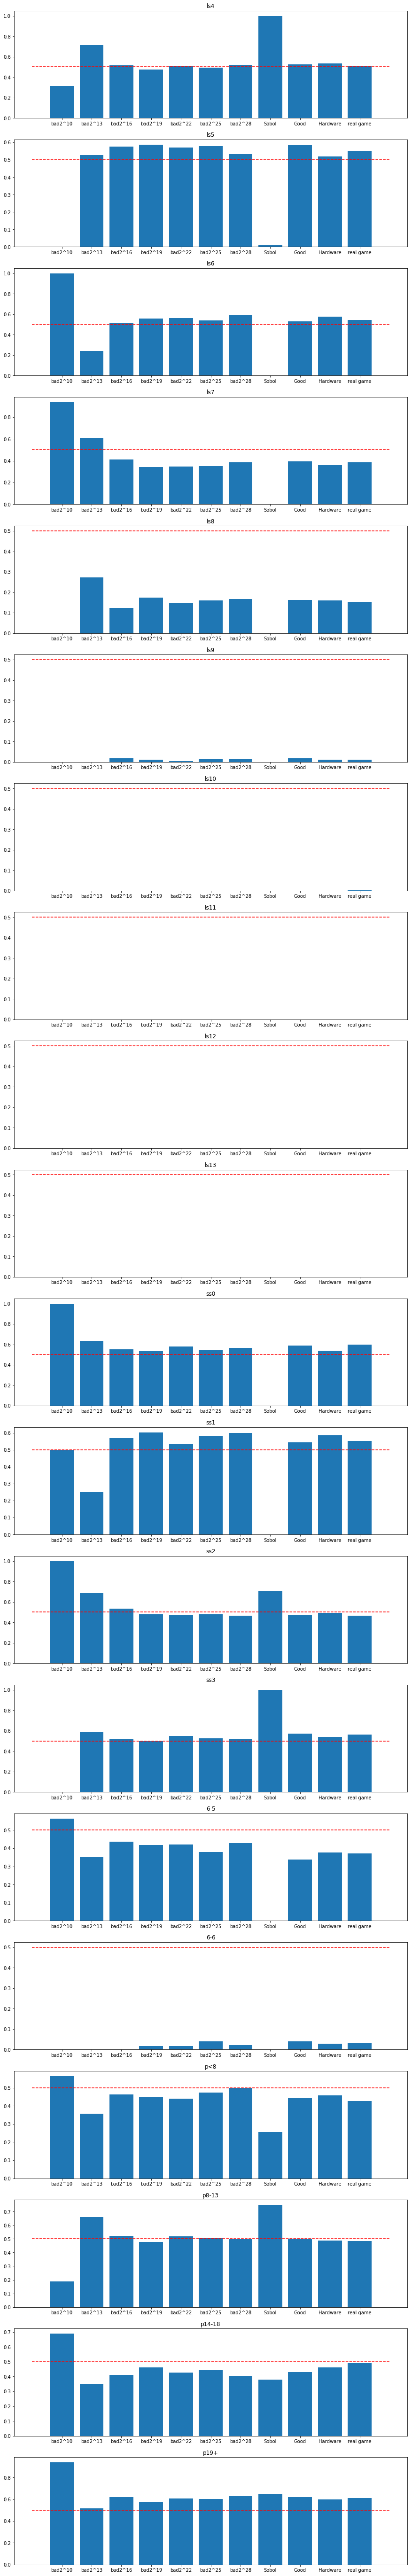

In [14]:
make_graphs_hist(feature_result, RS_name)